# Stock data notebook 2 - continued

In [50]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

### Read the data again but this time include a new column for 'Daily Return' using `pct_change` on the DataFrames

In [2]:
tech_stocks = ["AAPL", "GOOG", "MSFT", "AMZN"]
for ticker in tech_stocks:
    stock_df = pd.read_csv(f"./data/stock_data_2023/{ticker}.csv", parse_dates=["Date"])
    stock_df["Stock"] = ticker
    stock_df["Daily Return"] = stock_df["Adj Close"].pct_change() * 100
    stock_df.dropna(inplace=True)
    globals()[ticker] = stock_df
all_stocks = pd.concat([GOOG, MSFT, AMZN, AAPL])
all_stocks

,Date,Open,High,Low,Close,Adj Close,Volume,Stock,Daily Return
1,2023-01-04,91.010002,91.239998,87.800003,88.709999,88.609169,27046500,GOOG,-1.103673
2,2023-01-05,88.070000,88.209999,86.559998,86.769997,86.671371,23136100,GOOG,-2.186905
3,2023-01-06,87.360001,88.470001,85.570000,88.160004,88.059799,26612600,GOOG,1.601945
4,2023-01-09,89.195000,90.830002,88.580002,88.800003,88.699066,22996700,GOOG,0.725946
5,2023-01-10,86.720001,89.474998,86.699997,89.239998,89.138565,22855600,GOOG,0.495495
...,...,...,...,...,...,...,...,...,...
245,2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800,AAPL,-0.554741
246,2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542831,28919300,AAPL,-0.284090
247,2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700,AAPL,0.051790
248,2023-12-28,194.139999,194.660004,193.169998,193.580002,193.071426,34049900,AAPL,0.222629


### Are the Daily Return values for each stock normally distributed? Show some simple histograms wth KDE

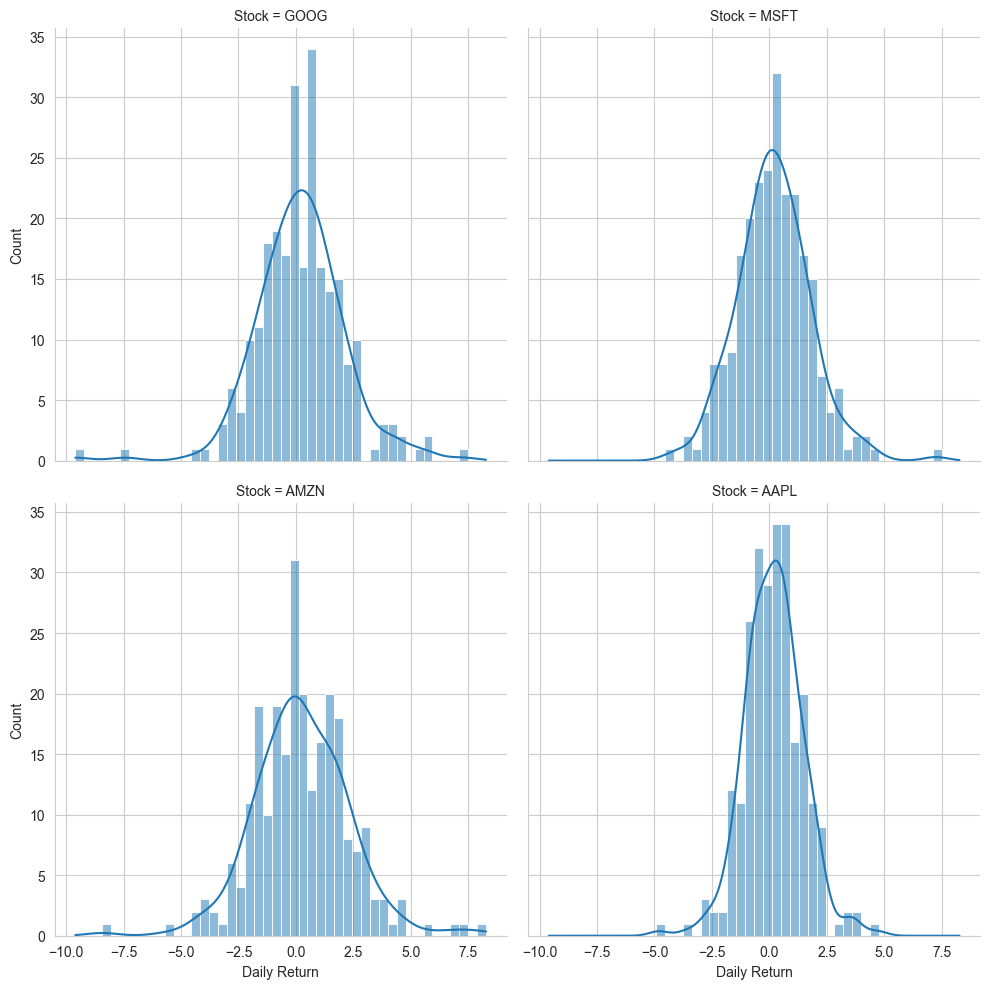

In [51]:
sns.displot(data=all_stocks, kind="hist", x="Daily Return", kde=True, col="Stock", col_wrap=2)

### They look pretty good, but lets also remove outliers using the IRQ method

In [61]:
tech_stocks = ["AAPL", "GOOG", "MSFT", "AMZN"]
stocks_no_outliers = {}
for ticker in tech_stocks:
    stock = all_stocks.loc[all_stocks["Stock"] == ticker].copy()
    # calculate IQR
    Q1 = stock["Daily Return"].quantile(0.25)
    Q3 = stock["Daily Return"].quantile(0.75)
    IQR = Q3 - Q1
    # identify outliers
    threshold = 1.5
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    no_outliers = stock[(stock["Daily Return"] >= lower_bound) & (stock["Daily Return"] <= upper_bound)]
    print(f"{ticker}: removed {250-len(no_outliers)} outliers out of {len(stock)}")
    stocks_no_outliers[ticker] = no_outliers
all_stocks_no_outliers = pd.concat(stocks_no_outliers.values())

AAPL: removed 9 outliers out of 249
GOOG: removed 10 outliers out of 249
MSFT: removed 9 outliers out of 249
AMZN: removed 7 outliers out of 249


### And check the plots again

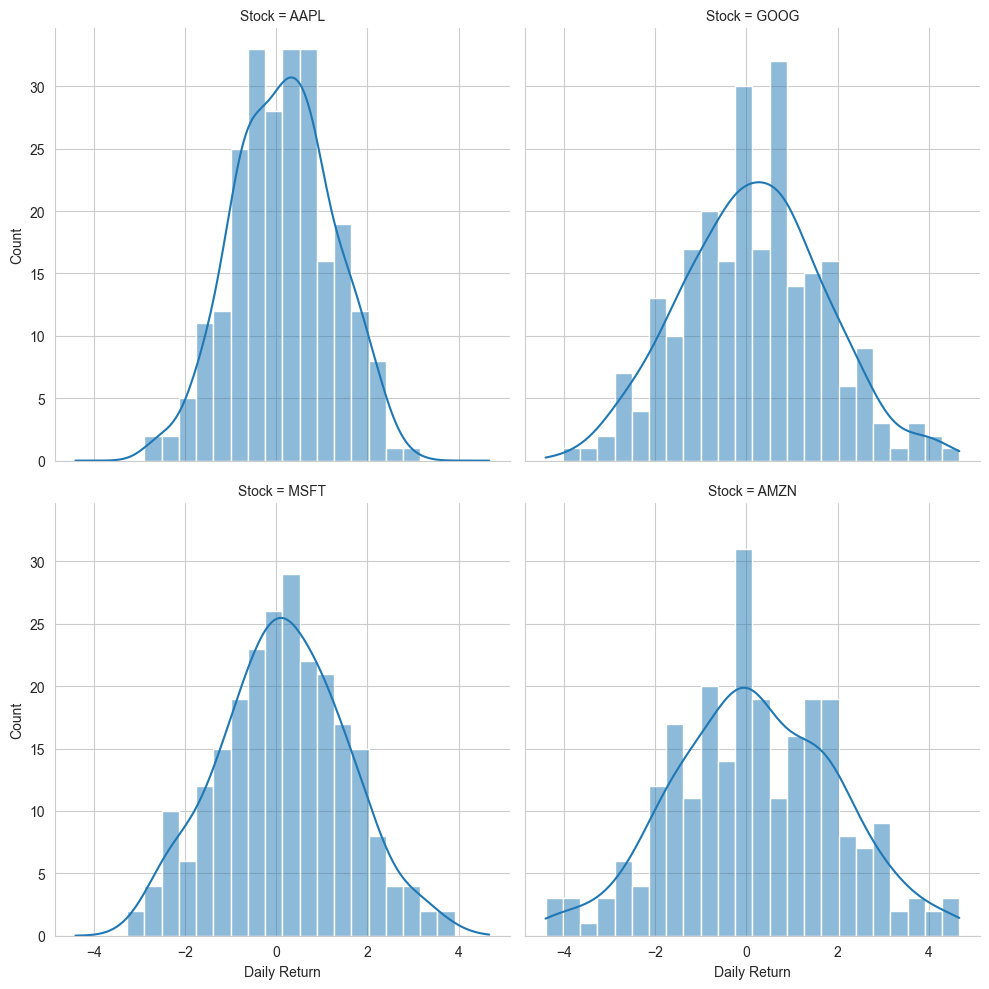

In [63]:
sns.displot(data=all_stocks_no_outliers, kind="hist", x="Daily Return", kde=True, col="Stock", col_wrap=2)

### They still look good, but can they be considered normal under the empirical rule (68-95-99.7)

In [65]:
from scipy.stats import zscore
for stock in stocks_no_outliers:
    print(f"### {stock}:")
    zscores = zscore(stocks_no_outliers[stock]["Daily Return"])
    one_sd = len(zscores[(zscores>-1) & (zscores<1)])/len(zscores)*100
    print(f"Probability of 1 std dev: {round(one_sd, 2)}")
    two_sd = len(zscores[(zscores>-2) & (zscores<2)])/len(zscores)*100
    print(f"Probability of 2 std dev: {round(two_sd, 2)}")
    three_sd = len(zscores[(zscores>-3) & (zscores<3)])/len(zscores)*100
    print(f"Probability of 3 std dev: {round(three_sd, 2)}")

### AAPL:
Probability of 1 std dev: 66.8
Probability of 2 std dev: 95.44
Probability of 3 std dev: 100.0
### GOOG:
Probability of 1 std dev: 68.33
Probability of 2 std dev: 95.42
Probability of 3 std dev: 100.0
### MSFT:
Probability of 1 std dev: 67.63
Probability of 2 std dev: 94.61
Probability of 3 std dev: 100.0
### AMZN:
Probability of 1 std dev: 69.55
Probability of 2 std dev: 94.24
Probability of 3 std dev: 100.0


### Certainly close enough for our purposes!

### ----------------------------------------------------------------------------

### Now lets start looking for any correlations...

### Use a `jointplot` to compare the Daily Return values for 2 of the stocks and add a Pearson correlation value

Text(0.1, 0.9, 'Pearson: 0.62\nPval: 0.0')

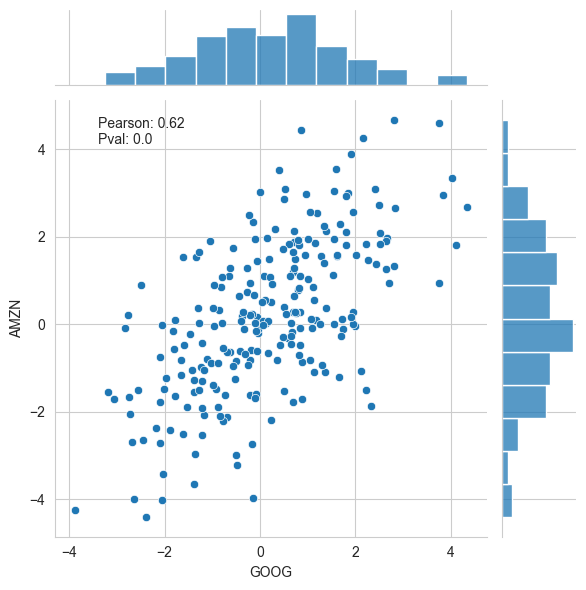

In [88]:
stock_dict = stocks_no_outliers
# Get the data for Google & Amazon & add them to a new DataFrame
s1 = stock_dict["GOOG"]["Daily Return"].rename("GOOG")
s2 = stock_dict["AMZN"]["Daily Return"].rename("AMZN")
two_stock_dr = pd.concat([s1, s2], axis=1)
two_stock_dr.dropna(inplace=True)
# Get the correlation value using scypi
import scipy as sp
r, p = sp.stats.pearsonr(x=two_stock_dr["GOOG"], y=two_stock_dr["AMZN"])
# Plot and get back the JointGrid
grid = sns.jointplot(data=two_stock_dr, kind="scatter", x="GOOG", y="AMZN")
# Get the Axes from the JointGrid
ax = grid.ax_joint
# Add text to the plot
ax.annotate(f"Pearson: {np.round(r, decimals=2)}\nPval: {np.round(p, decimals=2)}", xy=(0.1, 0.9), xycoords='axes fraction')

### Now lets do something similar for _all_ the stocks

In [89]:
# Select the 2 columns of data we're interested in and pivot
returns_df = all_stocks[["Stock", "Daily Return"]].pivot(columns="Stock", values="Daily Return")
returns_df

Stock,AAPL,AMZN,GOOG,MSFT
1,1.031420,-0.792357,-1.103673,-4.374316
2,-1.060460,-2.372558,-2.186905,-2.963781
3,3.679407,3.561115,1.601945,1.178533
4,0.408897,1.486988,0.725946,0.973635
5,0.445636,2.873171,0.495495,0.761709
...,...,...,...,...
245,-0.554741,-0.273010,0.648795,0.278421
246,-0.284090,-0.006514,0.070076,0.021358
247,0.051790,-0.045635,-0.966252,-0.157479
248,0.222629,0.026092,-0.113124,0.323462


### Get correlation values for this daily return data

In [90]:
returns_corr = returns_df.corr()
returns_corr

Stock,AAPL,AMZN,GOOG,MSFT
Stock,,,,
AAPL,1.000000,0.441677,0.536162,0.547988
AMZN,0.441677,1.000000,0.612112,0.575928
GOOG,0.536162,0.612112,1.000000,0.518318
MSFT,0.547988,0.575928,0.518318,1.000000


### Visualize the correlations with a seaborn heatmap

<AxesSubplot: xlabel='Stock', ylabel='Stock'>

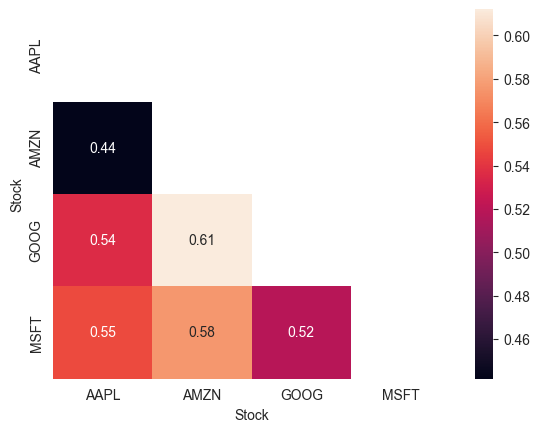

In [91]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(returns_corr, dtype=bool))
sns.heatmap(returns_corr, annot=True, mask=mask)

### Finally, a grid of all the pairs using multiple plot types. Seaborn is great for this

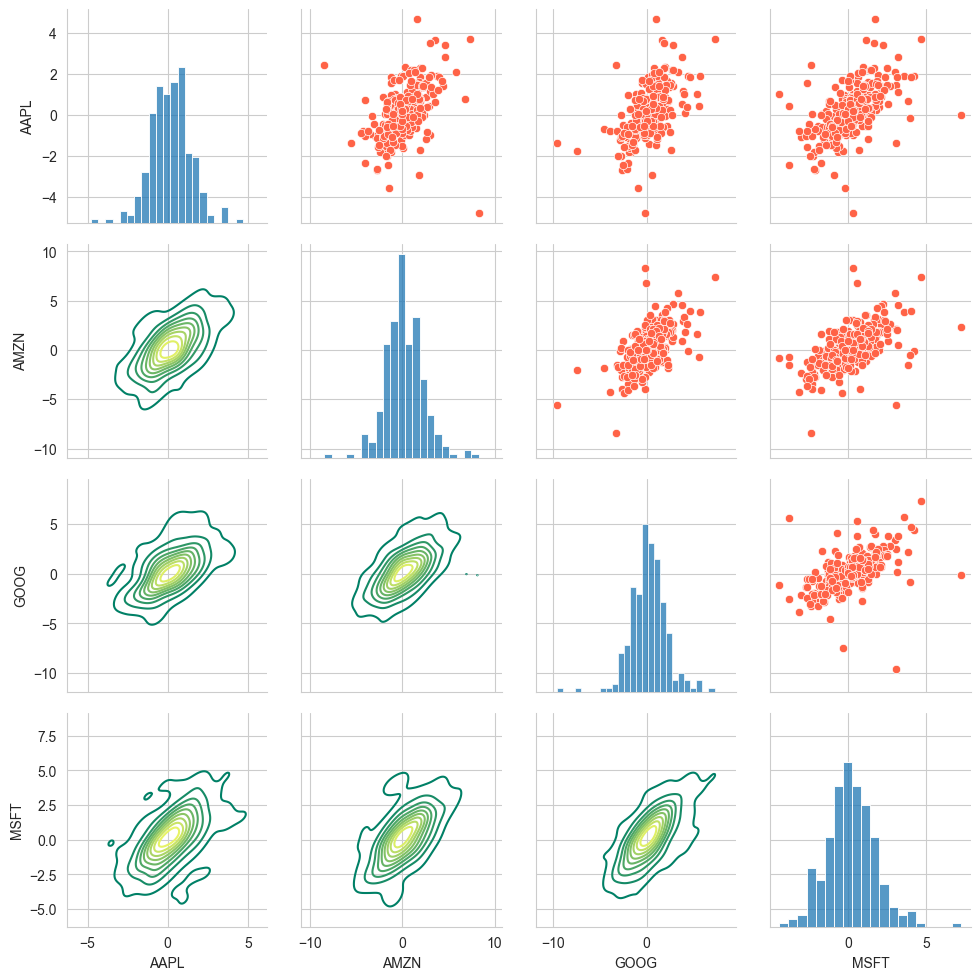

In [92]:
pg = sns.PairGrid(returns_df)
pg.map_diag(sns.histplot)
pg.map_upper(sns.scatterplot, color="tomato")
pg.map_lower(sns.kdeplot, cmap="summer")

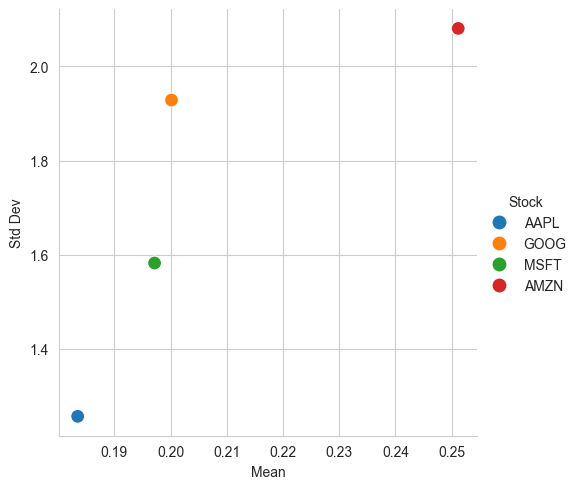

In [49]:
sns.set_style("whitegrid")
tech_stocks = ["AAPL", "GOOG", "MSFT", "AMZN"]
rows = []
for ticker in tech_stocks:
    rows.append([
        returns_df[ticker].mean(),
        returns_df[ticker].std(),
        ticker])

ra_df = DataFrame(rows, columns=["Mean", "Std Dev", "Stock"])
ra_df
sns.relplot(data=ra_df, x="Mean", y="Std Dev", hue="Stock", s=100)